Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset chargé : (7000, 14)

=== PERFORMANCE XGBOOST ===
Accuracy : 0.9954285714285714

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       393
           1       0.99      1.00      1.00      1357

    accuracy                           1.00      1750
   macro avg       1.00      0.99      0.99      1750
weighted avg       1.00      1.00      1.00      1750



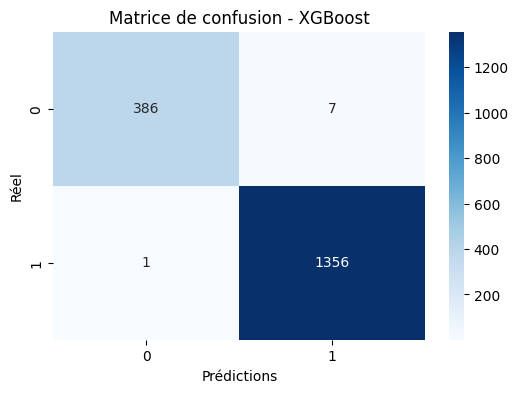


=== PERFORMANCE RANDOM FOREST ===
Accuracy : 0.9937142857142857

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       393
           1       0.99      1.00      1.00      1357

    accuracy                           0.99      1750
   macro avg       0.99      0.99      0.99      1750
weighted avg       0.99      0.99      0.99      1750



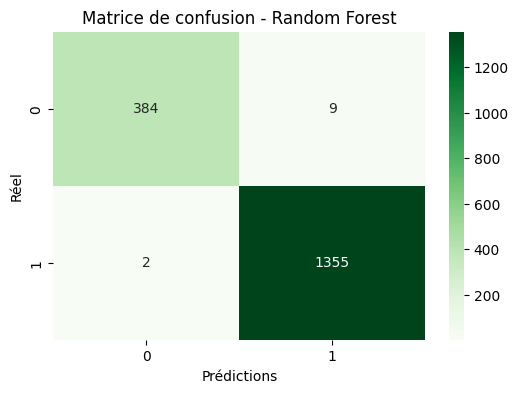


✅ Top 15 variables les plus importantes :
                             Feature  Importance
2                         moyenne_s2    0.403243
1                         moyenne_s1    0.306951
3                 nb_modules_echoues    0.192209
5              discipline_note_sur_5    0.062534
0                        moyenne_bac    0.013722
4             heures_travail_semaine    0.011805
6   satisfaction_parcours_note_sur_5    0.003915
10            type_bac_Mathématiques    0.000778
9              type_bac_Informatique    0.000731
14                  parcours_Licence    0.000723
15                   parcours_Master    0.000641
8              travail_parallele_Oui    0.000595
7              travail_parallele_Non    0.000590
13          parcours_Cycle Ingénieur    0.000554
11                 type_bac_Sciences    0.000537

✅ Modèles sauvegardés avec succès.


In [ ]:
# ==============================================================================
# ÉTAPE 3 : MODÉLISATION PRÉDICTIVE
# ==============================================================================

# ============================
# 1️⃣ MOUNT GOOGLE DRIVE
# ============================
from google.colab import drive
drive.mount('/content/drive')

# ============================
# 2️⃣ IMPORTATIONS
# ============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# ============================
# 3️⃣ CHARGEMENT DU DATASET
# ============================
dataset_path = "/content/drive/MyDrive/MP_python/dataset/dataset_reussite_etudiants_ISI.csv"
df = pd.read_csv(dataset_path)

# Nettoyage des noms de colonnes
df.columns = [c.strip().lower().replace(" ", "_").replace("é", "e") for c in df.columns]

print("✅ Dataset chargé :", df.shape)

# ============================
# 4️⃣ DÉFINITION DE LA CIBLE
# ============================
df["moyenne_generale"] = (df["moyenne_s1"] + df["moyenne_s2"]) / 2
df["reussite"] = df.apply(
    lambda row: 1 if row["moyenne_generale"] >= 10 and row["nb_modules_echoues"] < 3 else 0,
    axis=1
)

# ============================
# 5️⃣ VARIABLES EXPLICATIVES
# ============================

num_cols = [
    "moyenne_bac",
    "moyenne_s1",
    "moyenne_s2",
    "nb_modules_echoues",
    "heures_travail_semaine",
    "discipline_note_sur_5",
    "satisfaction_parcours_note_sur_5"
]

cat_cols = ["travail_parallele", "type_bac", "parcours"]

X = df[num_cols + cat_cols]
y = df["reussite"]

# ============================
# 6️⃣ PRÉTRAITEMENT
# ============================

preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

# ============================
# 7️⃣ TRAIN / TEST SPLIT
# ============================

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

# ============================
# ✅ MODÈLE 1 : XGBOOST
# ============================

xgb_model = Pipeline([
    ("preprocess", preprocess),
    ("model", XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss"
    ))
])

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("\n=== PERFORMANCE XGBOOST ===")
print("Accuracy :", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

# Matrice de confusion
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion - XGBoost")
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.show()

# ============================
# ✅ SAUVEGARDE DES MODÈLES
# ============================

os.makedirs("/content/drive/MyDrive/MP_python/modeles_sauvegardes", exist_ok=True)

joblib.dump(xgb_model, "/content/drive/MyDrive/MP_python/modeles_sauvegardes/xgboost_model.pkl")


print("\n✅ Modèles sauvegardés avec succès.")
